
In order to use this book, please install te required module using conda (or
other software)
```
conda install -c conda-forge abtem
```


# Configuration

In [1]:
#| code-fold: false
import numpy as np
potential_sampling = 0.05 # Angstrom
scan_sampling = 0.25 # Angstrom
slice_thickness = 0.5 # Angstrom

In [2]:
from ase.io import read
unit_cell = read("atom-models/WSe2_single_layer.cif")

from ase.visualize import view
#view(unit_cell)


Now, create a layer with the unit cell imported above. Here we can use
CrystalPotential to reduce the usage of the RAM.

(3.32707, 5.762654280338185)

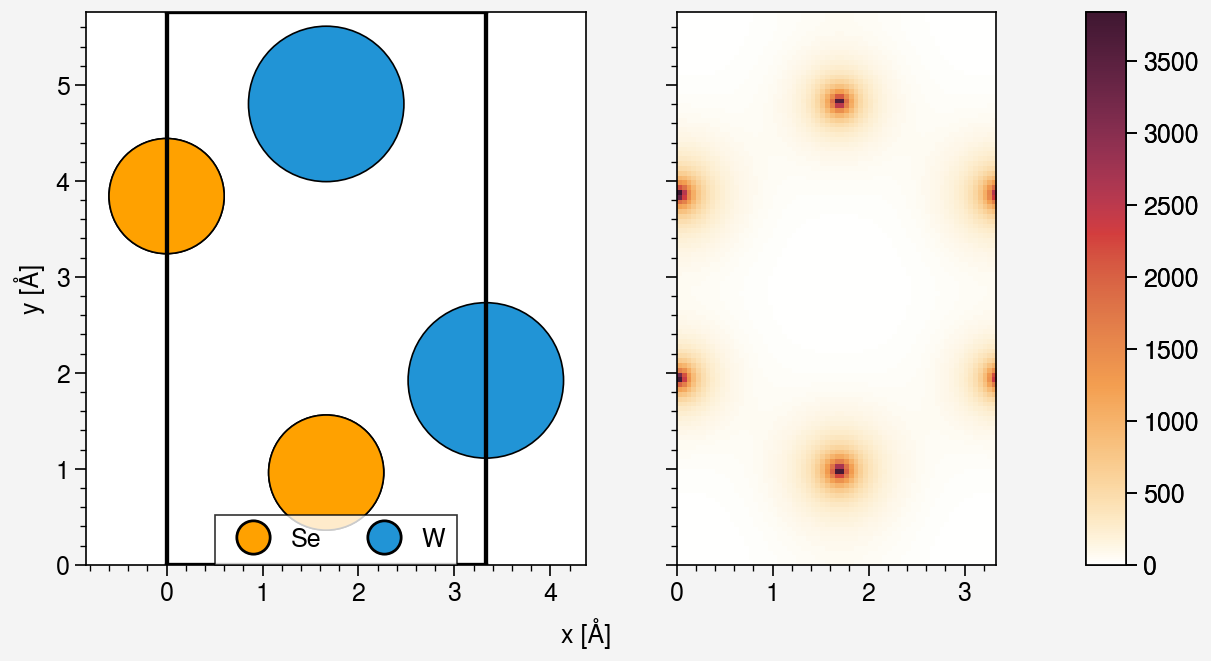

In [32]:
import abtem
from abtem.visualize import show_atoms
from abtem.structures import orthogonalize_cell
import proplot as pplt
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

model, transform = orthogonalize_cell(unit_cell, return_transform=True)

unit_potential = abtem.Potential(
    model,
    sampling=potential_sampling,
    slice_thickness=slice_thickness,
    projection="finite",
    parametrization="kirkland")

fig, (ax1, ax2) = pplt.subplots(nrows=1, ncols=2)
show_atoms(model, legend=True, ax=ax1)

x_length = np.linalg.norm(model.cell[0])
y_length = np.linalg.norm(model.cell[1])
m = ax2.imshow(unit_potential.project().array.T,
           origin="lower",
           extent=[0, x_length, 0, y_length])
ax2.colorbar(m, loc="r")

#pplt.show()
x_length, y_length


Now, create repeated cells to form an area.

In [5]:
repititions = (31, 18, 1)
potential = abtem.potentials.CrystalPotential(unit_potential, repititions)

print(f"There will be {len(potential)} slices.")
print(f"model dimension:")
print(f"    x: {potential.extent[0]}")
print(f"    y: {potential.extent[1]}")
print(f"Sampling rate:")
print(f"    x: {potential.sampling[0]} Å")
print(f"    y: {potential.sampling[1]} Å")

There will be 16 slices.
model dimension:
    x: 103.13917
    y: 103.72777704608733
Sampling rate:
    x: 0.04965776119402985 Å
    y: 0.05011003722033204 Å



# Build Probe and Scan

In [6]:
probe = abtem.Probe(
    energy=80e3,
    semiangle_cutoff=20
)
probe.grid.match(potential)

print(f"electron beam properties:")
print(f"    wavelength: {probe.wavelength} Å")
print(f"real space sampling rate:")
print(f"    x: {probe.sampling[0]} Å")
print(f"    y: {probe.sampling[1]} Å")
print(f"reciprocal space sampling rate:")
print(f"    Rx: {probe.angular_sampling[0]} mrad")
print(f"    Ry: {probe.angular_sampling[1]} mrad")

electron beam properties:
    wavelength: 0.04175716056489365 Å
real space sampling rate:
    x: 0.04965776012789819 Å
    y: 0.050110036509048536 Å
reciprocal space sampling rate:
    Rx: 0.40486229878912827 mrad
    Ry: 0.40256489001070256 mrad


In [7]:
probe.build().array.shape

(2077, 2070)

In [9]:
#| label: probe-image
#| fig-cap: Intensity image of the probe and its profile through the center.
(extent_x, extent_y) = probe.extent
plot_range = 10 # Angstrom
probe_intensity = probe.build().intensity()
lineprofile = abtem.measure.probe_profile(probe_intensity)
lineprofile.show(ax=ax2)
ax2.format(xlim=(extent_x/2-plot_range, extent_x/2+plot_range))
pplt.show()

fwhm = abtem.measure.calculate_fwhm(lineprofile)
print(f"FWHM of Probe: {fwhm} Å")

FWHM of Probe: 1.1465446394730905 Å



# Summary

There will be 16 slices.
model dimension:
    x: 103.13917
    y: 103.72777704608733
Sampling rate:
    x: 0.04965776119402985 Å
    y: 0.05011003722033204 Å
electron beam properties:
    wavelength: 0.04175716056489365 Å
real space sampling rate:
    x: 0.04965776012789819 Å
    y: 0.050110036509048536 Å
reciprocal space sampling rate:
    Rx: 0.40486229878912827 mrad
    Ry: 0.40256489001070256 mrad


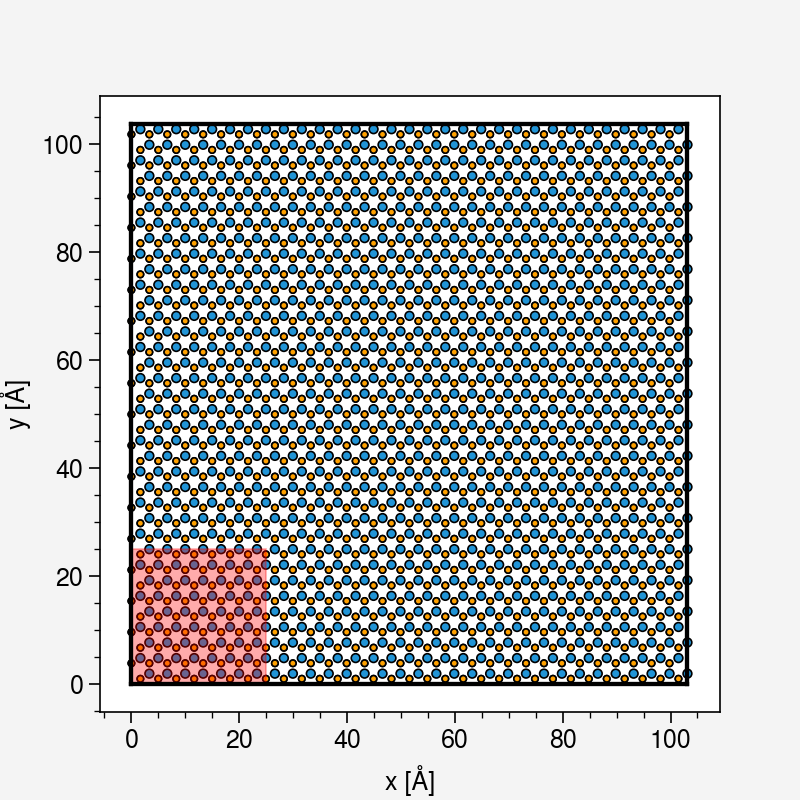

In [26]:
print(f"There will be {len(potential)} slices.")
print(f"model dimension:")
print(f"    x: {potential.extent[0]}")
print(f"    y: {potential.extent[1]}")
print(f"Sampling rate:")
print(f"    x: {potential.sampling[0]} Å")
print(f"    y: {potential.sampling[1]} Å")
print(f"electron beam properties:")
print(f"    wavelength: {probe.wavelength} Å")
print(f"real space sampling rate:")
print(f"    x: {probe.sampling[0]} Å")
print(f"    y: {probe.sampling[1]} Å")
print(f"reciprocal space sampling rate:")
print(f"    Rx: {probe.angular_sampling[0]} mrad")
print(f"    Ry: {probe.angular_sampling[1]} mrad")

detector = abtem.PixelatedDetector(max_angle=51.8223742450, resample="uniform")
grid_scan = abtem.GridScan(
    start=[0, 0],
    end=[0.25*100, 0.25*100],
    sampling=0.25
)

ax = abtem.show_atoms(model * repititions)
grid_scan.add_to_mpl_plot(ax)

In [27]:
measurements = probe.scan(grid_scan, potential=potential, detectors=detector, pbar=True)
measurements.write("IAMMeasurements_CrystalPotential.abtem.hdf5")

Scan:   0%|          | 0/10000 [00:00<?, ?it/s]

'IAMMeasurements_CrystalPotential.abtem.hdf5'

In [25]:
measurements.array.shape

(1, 1, 257, 257)